In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
import h5py 
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time


from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle
import pandas as pd

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay


In [2]:
def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    
def produceDataset(inputFileName,path,treeName):
    
    print("start preparing",inputFileName)
    file = uproot.open(path+inputFileName+".root")
    tree=file[treeName]
    VariableList=tree.keys()
    

    df = tree.arrays(filter_name=VariableList[0],library="pd") 
    for i in range(1,len(VariableList)):
        df=df.join(tree.arrays(filter_name=VariableList[i],library="pd"))



    return df

def getFourVector(pt,eta,phi):
   
    m=1 # precision issues. not sure why but m=1 makes that no negative invariant mass square.
    px=pt*np.cos(phi)
    py=pt*np.sin(phi)
    pz=pt*np.sinh(eta)
    E=np.sqrt(px**2+py**2+pz**2+m**2)
    return np.array([E,px,py,pz], dtype=np.float64)

def getInvM(v):
    m2=v[0]**2-v[1]**2-v[2]**2-v[3]**2
    
    return np.sqrt(m2)

def getMass(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    v=v1+v2+v3+v4
    m_reco=getInvM(v)
    return m_reco

def getThreeVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    

    output=np.concatenate([v1[1:],v2[1:],v3[1:],v4[1:]])
    return  np.transpose(output)

def getDot_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    
    dot=[]

#     dot.append(getInvM(v1+v1))
#     dot.append(getInvM(v2+v2))
#     dot.append(getInvM(v3+v3))
#     dot.append(getInvM(v4+v4))
    
    dot.append(getInvM(v1+v2))
    dot.append(getInvM(v1+v3))
    dot.append(getInvM(v1+v4))
    dot.append(getInvM(v2+v3))
    dot.append(getInvM(v2+v4))
    dot.append(getInvM(v3+v4))
    dot=np.array(dot)
    

    return np.transpose(dot)
    

In [3]:

nShots=2**12
nMaxIter=300
maxDatasetEvents=5000

Dir="/Users/lizhelun/Desktop/QC/Datasets/"

h4l_VV="ntuple_4mu_VV"
h4l_bkg="ntuple_4mu_bkg"

print("nShots = ",nShots)

nShots =  4096


In [4]:
h4l=produceDataset(h4l_VV,Dir,'HZZ4LeptonsAnalysisReduced')
bkg=produceDataset(h4l_bkg,Dir,'HZZ4LeptonsAnalysisReduced')

start preparing ntuple_4mu_VV
start preparing ntuple_4mu_bkg


In [5]:
m_reco_signal=getMass(h4l)
m_reco_bkg=getMass(bkg)

<Figure size 432x288 with 0 Axes>

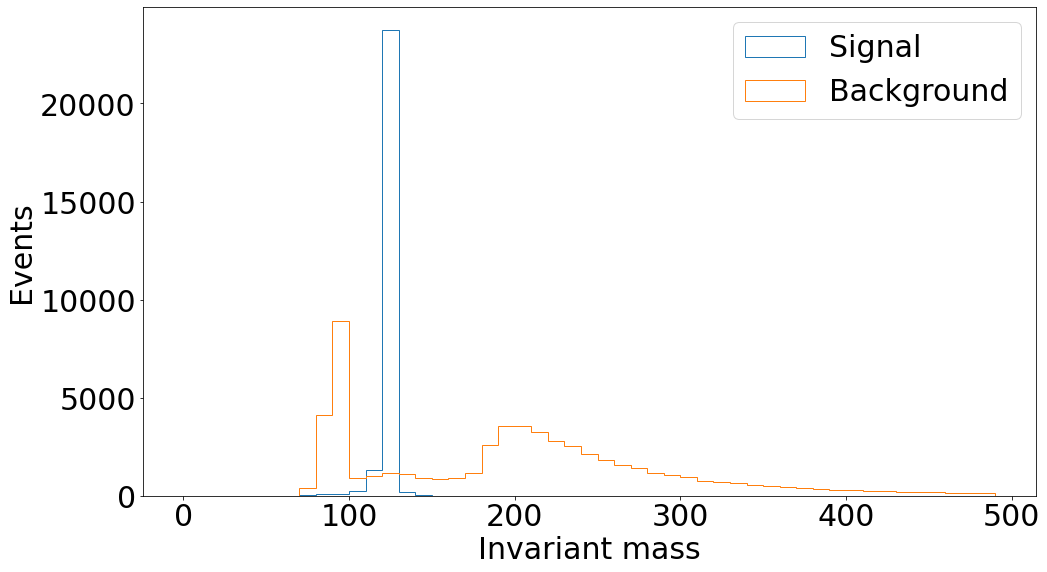

In [6]:
m_reco_signal=getMass(h4l)
m_reco_bkg=getMass(bkg)

LabelSize=30
plt.figure(1)
plt.figure(figsize=(16,9))
plt.hist(m_reco_signal,bins=np.arange(0,500,10),histtype='step',label='Signal');
plt.hist(m_reco_bkg,bins=np.arange(0,500,10),histtype='step',label='Background');

plt.xlabel('Invariant mass',fontsize=LabelSize)
plt.ylabel('Events',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)

In [7]:
sig_3vec=getThreeVectors_df(h4l)
bkg_3vec=getThreeVectors_df(bkg)

In [8]:
sig_dot=getDot_df(h4l)
bkg_dot=getDot_df(bkg)

In [9]:
def split(X,y,normalize=True):
    train_ratio=0.6
    X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
    #Normalizing everythings:
    if normalize:
        Max=X_train.max()
        X_train=np.pi*2*X_train/Max
        X_val=np.pi*2*X_val/Max
        X_test=np.pi*2*X_test/Max
        
    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [10]:
X_3=np.concatenate([sig_3vec[0:maxDatasetEvents],bkg_3vec[0:maxDatasetEvents]])
y_3=np.concatenate([np.ones(sig_3vec[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_3vec[0:maxDatasetEvents].shape[0])])
X_3,y_3=shuffle(X_3,y_3,random_state=1000)

X_train_3,y_train_3,X_val_3,y_val_3,X_test_3,y_test_3=split(X_3,y_3)

In [11]:
X_dot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot=np.concatenate([np.ones(sig_dot[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_dot[0:maxDatasetEvents].shape[0])])
X_dot,y_dot=shuffle(X_dot,y_dot,random_state=1000)

X_train_dot,y_train_dot,X_val_dot,y_val_dot,X_test_dot,y_test_dot=split(X_dot,y_dot)

In [12]:
inv_dot=np.concatenate([m_reco_signal[0:maxDatasetEvents],m_reco_bkg[0:maxDatasetEvents]])
inv_dot=shuffle(inv_dot,random_state=1000)
inv_dot_train,inv_doty_train_3,inv_dot_val,inv_doty_val,inv_dot_test,inv_doty_test_3=split(inv_dot,y_3,normalize=False)

In [13]:
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import SparsePauliOp

from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR


In [14]:
#regressor:
def getEstimator_rotPerm(num_layers,N_particles):

    n_params=num_layers*2
    num_qubits=int((N_particles-1)*N_particles/2)

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
    weights = ParameterVector("weight", n_params)
    print(f"weight parameters: {[str(item) for item in weights.params]}")

    inputParams_index=0
    params_index=0

    qc.compose(feature_map, inplace=True) 

    for layer in range(num_layers):

            for j in np.arange(0,num_qubits,1):
                qc.ry(weights[params_index],j)

            params_index += 1

            for i in np.arange(0,num_qubits,1):
                for k in np.arange(i,num_qubits,1):
                    if i!=k:
                        qc.rzz(weights[params_index],i,k)

            params_index += 1

            qc.barrier()

    observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
    estimator_qnn_rotPerm = EstimatorQNN(
        circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
    )
    return estimator_qnn_rotPerm

In [18]:
def cost_func(params,estimator,X,y):
    """
    input: 
        params: list of parameters
        num_qubit: number of qubits
        num_layers: number of layers
        j_coupling: coeffecient in ZZ terms
        h_coupling: coefficient in X terms
        ansatz_type: type of ansatz (HEA or HVA)
        
    output: value of cost function (VEV of Hamiltonian)
    
    global variables:
        cost_val_list: list of cost function values
    """
    global cost_val_list
    
    
    pred = estimator.forward(X,params[0:-1]).flatten()
    pred=-abs(pred-params[-1])
    cost_val=((pred-y)**2).sum()
    
    cost_val_list.append(cost_val)
    
    clear_output(wait=True)
    
    plt.plot(np.arange(0,len(cost_val_list)), cost_val_list)
    plt.xlabel('iteration')
    plt.ylabel('cost function')
    plt.legend()
    plt.show()
    return cost_val

def getBestTheshold(est,params,X_test,y_test):
    y_predict=est.forward(X_test,params).flatten()
    #plt.hist(y_predict)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=1)

    bestValidation=0
    threshold_best=0
    for t in thresholds:
        y=y_predict.copy().flatten()
        y[y>t]=1
        y[y<t]=-1
        diff=y-y_test
        val=diff[diff==0].shape[0]/y.shape[0]
        if val>bestValidation:
            bestValidation=val
            threshold_best=t
            print(val,threshold_best)
    return threshold_best

def computeAccuracy(est,params,X_test,y_test,threshold):
    y=est.forward(X_test,params).flatten()

    y[y>=threshold]=1
    y[y<threshold]=-1
    diff=y-y_test
    acc=diff[diff==0].shape[0]/y.shape[0]
    return acc
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


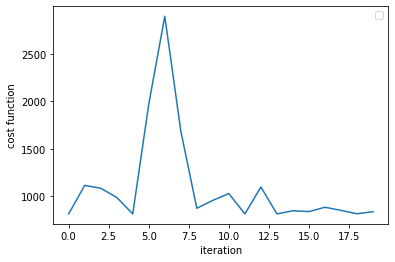

In [19]:
method='COBYLA'
maxEvents=1000
MaxIter=20
estimator_qnn_rotPerm1=getEstimator_rotPerm(2,4)
initial_weights=np.pi*2*np.random.rand(estimator_qnn_rotPerm1.num_weights+1)
cost_val_list=[]

res_rotPerm1 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_qnn_rotPerm1,X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])) #minimize cost function via scipy
cost_val_list_rotPerm1=cost_val_list
params_rotPerm1=res_rotPerm1.x

In [25]:
yy=estimator_qnn_rotPerm1.forward(X_train_dot[0:maxEvents],params_rotPerm1[0:-1]).flatten()
yy=-abs(yy-params_rotPerm1[-1])

<Figure size 432x288 with 0 Axes>

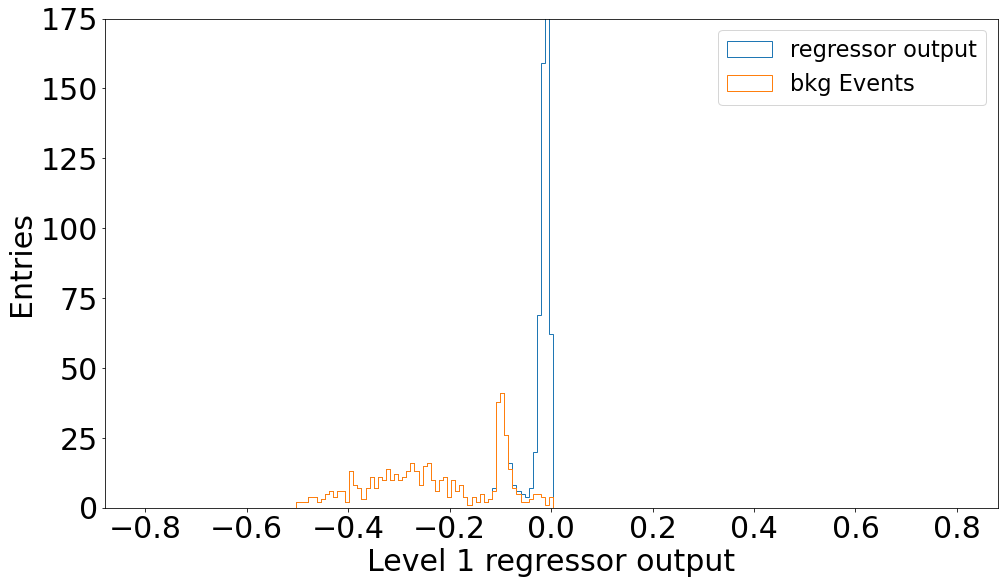

In [28]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.8,200)
#bins=np.linspace(-0,0.1,100)
Max=175
plt.hist(yy,bins=bins,histtype='step',label='regressor output')
plt.hist(yy[y_train_dot[0:maxEvents]==-1],bins=bins,histtype='step',label='bkg Events')
#plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='cut')

plt.ylim(0,Max)
plt.xlabel('Level 1 regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

In [29]:
y_predict=yy
fpr, tpr, thresholds = metrics.roc_curve(y_train_dot[0:maxEvents], yy, pos_label=1)

bestValidation=0
threshold_best=0
for t in thresholds:
    y=y_predict.copy().flatten()
    y[y>t]=1
    y[y<t]=-1
    diff=y-y_train_dot[0:maxEvents]
    val=diff[diff==0].shape[0]/y.shape[0]
    if val>bestValidation:
        bestValidation=val
        threshold_best=t
        print(val,threshold_best)

0.512 inf
0.524 -0.0010441680065710335
0.532 -0.0017760071780137388
0.56 -0.0034823621599660015
0.645 -0.007600264146496005
0.753 -0.012356595196150677
0.783 -0.013911516257361145
0.8 -0.01454621101307424
0.818 -0.01539968960775917
0.911 -0.021704613368231374
0.946 -0.025516465842644664
0.949 -0.026269364234429327
0.955 -0.027453968023046504
0.957 -0.02826406768653178
0.962 -0.03133339070726643
0.966 -0.03291671313304628
0.967 -0.03492964667702064
0.969 -0.040373149862697244


In [ ]:
threshold_best_rotPerm1=getBestTheshold(estimator_qnn_rotPerm1,params_rotPerm1,X_train_dot[0:maxEvents],y_train_dot[0:maxEvents])
print("Best level 1 threshold is",threshold_best_rotPerm1)
print('---------------------------')
y_rotPerm1=estimator_qnn_rotPerm1.forward(X_train_dot[0:maxEvents],params_rotPerm1).flatten()
y_rotPerm1[y_rotPerm1>=threshold_best_rotPerm1]=1
y_rotPerm1[y_rotPerm1<threshold_best_rotPerm1]=-1

diff=y_rotPerm1-y_train_dot[0:maxEvents]
acc_sig_rotPerm1=(diff[y_rotPerm1==1][diff[y_rotPerm1==1]==0]).shape[0]/diff[y_rotPerm1==1].shape[0]
acc_bkg_rotPerm1=(diff[y_rotPerm1==-1][diff[y_rotPerm1==-1]==0]).shape[0]/diff[y_rotPerm1==-1].shape[0]
acc_rotPerm1=(diff[diff==0]).shape[0]/diff.shape[0]
print("Accuracy of signal-like events in training dataset is ",acc_sig_rotPerm1)
print("Accuracy of bkg-like events in training dataset is ",acc_bkg_rotPerm1)
print("Training accuracy overall is ",acc_rotPerm1)
acc_rotPerm1_test=computeAccuracy(estimator_qnn_rotPerm1,params_rotPerm1,X_test_dot,y_test_dot,threshold_best_rotPerm1)
print("Test accuracy of level 1 estimator is ",acc_rotPerm1_test)

In [ ]:
y_rotPerm1=estimator_qnn_rotPerm1.forward(X_train_dot[0:maxEvents],params_rotPerm1).flatten()

X_2=X_train_dot[0:maxEvents][y_rotPerm1>=threshold_best_rotPerm1]
y_2=y_train_dot[0:maxEvents][y_rotPerm1>=threshold_best_rotPerm1]

In [ ]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.8,200)
Max=175
plt.hist(y_rotPerm1,bins=bins,histtype='step',label='regressor output')
plt.hist(y_rotPerm1[y_train_dot[0:maxEvents]==-1],bins=bins,histtype='step',label='bkg Events')
#plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='cut')

plt.ylim(0,Max)
plt.xlabel('Level 1 regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

In [ ]:
threshold_best_rotPerm2=getBestTheshold(estimator_qnn_rotPerm1,params_rotPerm1,X_2,y_2)

In [ ]:
threshold_best_rotPerm2

In [ ]:
#Since signal like events accuracy is still low, train a second level network for it
X_2=X_train_dot[0:maxEvents][y_rotPerm1==1]
y_2=y_train_dot[0:maxEvents][y_rotPerm1==1]
estimator_qnn_rotPerm2=getEstimator_rotPerm(2,4)
initial_weights=np.pi*2*np.random.rand(estimator_qnn_rotPerm2.num_weights)
cost_val_list=[]

res_rotPerm2 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_qnn_rotPerm2,X_2, y_2)) #minimize cost function via scipy
cost_val_list_rotPerm2=cost_val_list
params_rotPerm2=res_rotPerm2.x

In [ ]:
threshold_best_rotPerm2=getBestTheshold(estimator_qnn_rotPerm2,params_rotPerm2,X_2,y_2)
print("Best level 1 threshold is",threshold_best_rotPerm1)
print('---------------------------')
y_rotPerm2=estimator_qnn_rotPerm2.forward(X_2,params_rotPerm2).flatten()
y_rotPerm2[y_rotPerm2>=threshold_best_rotPerm2]=1
y_rotPerm2[y_rotPerm2<threshold_best_rotPerm2]=-1

diff=y_rotPerm2-y_2
acc_sig_rotPerm2=(diff[y_rotPerm2==1][diff[y_rotPerm2==1]==0]).shape[0]/diff[y_rotPerm2==1].shape[0]
acc_bkg_rotPerm2=(diff[y_rotPerm2==-1][diff[y_rotPerm2==-1]==0]).shape[0]/diff[y_rotPerm2==-1].shape[0]
acc_rotPerm2=(diff[diff==0]).shape[0]/diff.shape[0]
print("Accuracy of signal-like events in selected training dataset is ",acc_sig_rotPerm2)
print("Accuracy of bkg-like events in selected  training dataset is ",acc_bkg_rotPerm2)
print("Selected training accuracy overall is ",acc_rotPerm2)


In [ ]:
#Make final prediction:
y_pred=estimator_qnn_rotPerm1.forward(X_test_dot,params_rotPerm1).flatten()
y_pred[y_pred<threshold_best_rotPerm1]=-1
y_pred[y_pred>threshold_best_rotPerm1]=1

y_pred2=estimator_qnn_rotPerm2.forward(X_test_dot[y_pred==1],params_rotPerm2).flatten()
y_pred2[y_pred2<threshold_best_rotPerm2]=-1
y_pred2[y_pred2>threshold_best_rotPerm2]=1
y_pred[y_pred==1]=y_pred2

diff=y_pred-y_test_dot
acc_rotPerm=diff[diff==0].shape[0]/diff.shape[0]
print("final accuracy = ",acc_rotPerm)

No symmetry

In [ ]:
def getEstimator_baseline(num_layers,num_qubits):

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
    ansatz=RealAmplitudes(num_qubits, reps=num_layers)

    qc.compose(feature_map, inplace=True) 
    qc.compose(ansatz,inplace=True)  

    observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
    estimator_qnn= EstimatorQNN(
        circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
    )
    return estimator_qnn

In [ ]:
num_qubits=X_3.shape[1]
estimator_baseline1=getEstimator_baseline(2,num_qubits)

In [ ]:
method='COBYLA'
maxEvents=1000
MaxIter=300
num_qubits=X_3.shape[1]
estimator_baseline1=getEstimator_baseline(2,num_qubits)
initial_weights=np.pi*2*np.random.rand(estimator_baseline1.num_weights)
cost_val_list=[]

res_baseline1 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_baseline1,X_train_3[0:maxEvents], y_train_3[0:maxEvents])) #minimize cost function via scipy
cost_val_list_rotPerm1=cost_val_list
params_baseline1=res_baseline1.x

In [ ]:
threshold_best_baseline1=getBestTheshold(estimator_baseline1,params_baseline1,X_train_3[0:maxEvents],y_train_3[0:maxEvents])
print("Best level 1 threshold is",threshold_best_baseline1)
print('---------------------------')
y_baseline1=estimator_baseline1.forward(X_train_3[0:maxEvents],params_baseline1).flatten()
y_baseline1[y_baseline1>=threshold_best_baseline1]=1
y_baseline1[y_baseline1<threshold_best_baseline1]=-1

diff=y_baseline1-y_train_3[0:maxEvents]
acc_sig_baseline1=(diff[y_baseline1==1][diff[y_baseline1==1]==0]).shape[0]/diff[y_baseline1==1].shape[0]
acc_bkg_baseline1=(diff[y_baseline1==-1][diff[y_baseline1==-1]==0]).shape[0]/diff[y_baseline1==-1].shape[0]
acc_baseline1=(diff[diff==0]).shape[0]/diff.shape[0]
print("Accuracy of signal-like events in training dataset is ",acc_sig_baseline1)
print("Accuracy of bkg-like events in training dataset is ",acc_bkg_baseline1)
print("Training accuracy overall is ",acc_baseline1)
acc_baseline1_test=computeAccuracy(estimator_baseline1,params_baseline1,X_test_3,y_test_3[0:maxEvents],threshold_best_baseline1)
print("Test accuracy of level 1 estimator is ",acc_baseline1_test)

In [ ]:
#Since signal like events accuracy is still low, train a second level network for it
X_2=X_train_3[0:maxEvents][y_baseline1==1]
y_2=y_train_3[0:maxEvents][y_baseline1==1]
estimator_baseline2=getEstimator_baseline(2,num_qubits)
initial_weights=np.pi*2*np.random.rand(estimator_baseline2.num_weights)
cost_val_list=[]

res_baseline2 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_baseline2,X_2, y_2)) #minimize cost function via scipy
cost_val_list_baseline2=cost_val_list
params_baseline2=res_baseline2.x

threshold_best_baseline2=getBestTheshold(estimator_baseline2,params_baseline2,X_2,y_2)
print("Best level 2 threshold is",threshold_best_baseline2)
print('---------------------------')
y_baseline2=estimator_baseline2.forward(X_2,params_baseline2).flatten()
y_baseline2[y_baseline2>=threshold_best_baseline2]=1
y_baseline2[y_baseline2<threshold_best_baseline2]=-1

diff=y_baseline2-y_2
acc_sig_baseline2=(diff[y_baseline2==1][diff[y_baseline2==1]==0]).shape[0]/diff[y_baseline2==1].shape[0]
acc_bkg_baseline2=(diff[y_baseline2==-1][diff[y_baseline2==-1]==0]).shape[0]/diff[y_baseline2==-1].shape[0]
acc_baseline2=(diff[diff==0]).shape[0]/diff.shape[0]
print("Accuracy of signal-like events in selected training dataset is ",acc_sig_baseline2)
print("Accuracy of bkg-like events in selected training dataset is ",acc_bkg_baseline2)
print("Selected training accuracy overall is ",acc_baseline2)


In [ ]:
#Since signal like events accuracy is still low, train a second level network for it
X_3=X_train_3[0:maxEvents][y_baseline1==-1]
y_3=y_train_3[0:maxEvents][y_baseline1==-1]
estimator_baseline3=getEstimator_baseline(2,num_qubits)
initial_weights=np.pi*2*np.random.rand(estimator_baseline3.num_weights)
cost_val_list=[]

res_baseline3 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_baseline3,X_3, y_3)) #minimize cost function via scipy
cost_val_list_baseline3=cost_val_list
params_baseline3=res_baseline3.x

threshold_best_baseline3=getBestTheshold(estimator_baseline3,params_baseline3,X_3,y_3)
print("Best level 2 threshold is",threshold_best_baseline3)
print('---------------------------')
y_baseline3=estimator_baseline3.forward(X_3,params_baseline3).flatten()
y_baseline3[y_baseline3>=threshold_best_baseline3]=1
y_baseline3[y_baseline3<threshold_best_baseline3]=-1

diff=y_baseline3-y_3
acc_sig_baseline3=(diff[y_baseline3==1][diff[y_baseline3==1]==0]).shape[0]/diff[y_baseline3==1].shape[0]
acc_bkg_baseline3=(diff[y_baseline3==-1][diff[y_baseline3==-1]==0]).shape[0]/diff[y_baseline3==-1].shape[0]
acc_baseline3=(diff[diff==0]).shape[0]/diff.shape[0]
print("Accuracy of signal-like events in selected training dataset is ",acc_sig_baseline3)
print("Accuracy of bkg-like events in selected training dataset is ",acc_bkg_baseline3)
print("Selected training accuracy overall is ",acc_baseline3)


In [ ]:
#Make final prediction:
y_pred=estimator_baseline1.forward(X_test_3,params_baseline1).flatten()
y_pred[y_pred<threshold_best_baseline1]=-1
y_pred[y_pred>threshold_best_baseline1]=1

y_pred_final=y_pred.copy()

diff=y_pred-y_test_3
acc_baseline=diff[diff==0].shape[0]/diff.shape[0]
print("level 1 accuracy = ",acc_baseline)

y_pred2=estimator_baseline2.forward(X_test_3[y_pred==1],params_baseline2).flatten()
y_pred2[y_pred2<threshold_best_baseline2]=-1
y_pred2[y_pred2>threshold_best_baseline2]=1
y_pred_final[y_pred==1]=y_pred2


y_pred3=estimator_baseline3.forward(X_test_3[y_pred==-1],params_baseline2).flatten()
y_pred3[y_pred3<threshold_best_baseline3]=-1
y_pred3[y_pred3>threshold_best_baseline3]=1
y_pred_final[y_pred==-1]=y_pred3

diff=y_pred_final-y_test_3
acc_baseline=diff[diff==0].shape[0]/diff.shape[0]
print("final accuracy = ",acc_baseline)

In [ ]:
y_rotPerm1=estimator_qnn_rotPerm1.forward(X_test_dot,params_rotPerm1).flatten()
y_baseline1=estimator_baseline1.forward(X_train_3[0:maxEvents],params_baseline1).flatten()

In [ ]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.5,200)
Max=175
plt.hist(y_baseline1,bins=bins,histtype='step',label='Baseline',rwidth=100)
plt.hist(y_rotPerm1,bins=bins,histtype='step',label='Rotation+Permutation')
plt.plot([threshold_best_baseline1]*Max,np.arange(0,Max,1),label='Baseline cut')
plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='Rotation+Permutation cut')

plt.ylim(0,Max)
plt.xlabel('Level 1 regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

Classical method

In [ ]:
from keras import utils 
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import sklearn.neural_network as skl_nn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate 



In [ ]:

def getFourVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    

    output=np.concatenate([v1,v2,v3,v4])
    return  np.transpose(output)

sig_4vec=getFourVectors_df(h4l)
bkg_4vec=getFourVectors_df(bkg)

X_4=np.concatenate([sig_4vec[0:maxDatasetEvents],bkg_4vec[0:maxDatasetEvents]])

maxEvents=5000
n_neurons=10

X_onehot=np.concatenate([sig_4vec[0:maxDatasetEvents],bkg_4vec[0:maxDatasetEvents]])
y_onehot=np.concatenate([np.ones(sig_4vec[0:maxDatasetEvents].shape[0]),np.zeros(bkg_4vec[0:maxDatasetEvents].shape[0])])
y_onehot= utils.to_categorical(y_onehot, 2)
X_onehot,y_onehot=shuffle(X_onehot,y_onehot,random_state=1000)
X_dot_onehot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot_onehot=np.concatenate([np.ones(sig_4vec[0:maxDatasetEvents].shape[0]),np.zeros(bkg_4vec[0:maxDatasetEvents].shape[0])])
X_dot_onehot,y_dot_onehot=shuffle(X_dot_onehot,y_dot_onehot,random_state=1000)

In [ ]:
maxEvents=5000
#One layer:
n_neurons_list=[1,2,3,4,5]

validation_list_5e3=[]
validation_list_error_5e3=[]
nParams_list_5e3=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=2000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=X_onehot.shape[1]*n_neurons_list[i]+n_neurons_list[i]
    
    validation_list_5e3.append(tmp_validation_list.mean())
    validation_list_error_5e3.append(tmp_validation_list.std())
    nParams_list_5e3.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons_list[i])

In [ ]:
maxEvents=1000
#One layer:
n_neurons_list=[1,2,3,4,5]

validation_list_1e3=[]
validation_list_error_1e3=[]
nParams_list_1e3=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=2000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=X_onehot.shape[1]*n_neurons_list[i]+n_neurons_list[i]
    
    validation_list_1e3.append(tmp_validation_list.mean())
    validation_list_error_1e3.append(tmp_validation_list.std())
    nParams_list_1e3.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons_list[i])

In [ ]:
maxEvents=500
#One layer:
n_neurons_list=[1,2,3,4,5]

validation_list_5e2=[]
validation_list_error_5e2=[]
nParams_list_5e2=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=2000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=X_onehot.shape[1]*n_neurons_list[i]+n_neurons_list[i]
    
    validation_list_5e2.append(tmp_validation_list.mean())
    validation_list_error_5e2.append(tmp_validation_list.std())
    nParams_list_5e2.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons_list[i])

In [ ]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
plt.errorbar(nParams_list_5e3,validation_list_5e3,yerr=validation_list_error_5e3,label="nEvents = 5000",
            marker='o', markersize=10,capsize=10,
            linestyle='none')
plt.errorbar(nParams_list_1e3,validation_list_1e3,yerr=validation_list_error_1e3,label="nEvents = 1000",
             marker='o', markersize=10,capsize=10,
            linestyle='none')

plt.errorbar(nParams_list_5e2,validation_list_5e2,yerr=validation_list_error_5e2,label="nEvents = 500",
            marker='o', markersize=10,capsize=10,
            linestyle='none')
plt.ylim(0.5,1)

plt.xlabel('Number of parameters',fontsize=LabelSize)
plt.ylabel('Accuracy',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)
#plt.xscale('log')